# Part 4: Predictive analysis
In this part we will train three predictive models on the data set and evaluate thier performance. The models are meant to predict the number of rentals given certain conditions (date and weather).

To train the models we use six features: hour, weekday, month, temperature, precipation, wind speed.

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime as dt

from yellowbrick.target import FeatureCorrelation

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

path = r"D:\Git\aa_project\Abgabe\Data"
path_fig = r"D:\Git\aa_project\Abgabe\Figures"

# 1. Predictive analysis perparation

## 1.1 Data import

In [222]:
#Berlin
df_b_base = pd.read_csv(path + r"\berlin_final.csv")
df_b_w = pd.read_csv(path + r"\berlin_weather.csv")

# Frankfurt
df_f_base = pd.read_csv(path + r"\frankfurt_final.csv")
df_f_w = pd.read_csv(path + r"\frankfurt_weather.csv")

In [223]:
def get_trips_berlin(datetime):
    return len(df_b_base[(df_b_base["month"] == datetime.month) & (df_b_base["date"] == datetime.day) & (df_b_base["hour"] == datetime.hour)].index)

def get_trips_frankfurt(datetime):
    return len(df_f_base[(df_f_base["month"] == datetime.month) & (df_f_base["date"] == datetime.day) & (df_f_base["hour"] == datetime.hour)].index)

In [224]:
df_f_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_f_w.datetime = pd.to_datetime(df_f_w.datetime)
df_f_w["num_trips"] = df_f_w["datetime"].apply(get_trips_berlin)

df_b_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_b_w.datetime = pd.to_datetime(df_b_w.datetime)
df_b_w["num_trips"] = df_b_w["datetime"].apply(get_trips_frankfurt)

In [225]:
def get_month(datetime):
    return datetime.month
def get_hour(datetime):
    return datetime.hour
def get_weekday(datetime):
    return datetime.weekday() + 1

In [226]:
df_f_w['month'] = df_f_w['datetime'].apply(get_month)
df_f_w['hour'] = df_f_w['datetime'].apply(get_hour)
df_f_w['weekday'] = df_f_w['datetime'].apply(get_weekday)

In [227]:
df_b_w['month'] = df_b_w['datetime'].apply(get_month)
df_b_w['hour'] = df_b_w['datetime'].apply(get_hour)
df_b_w['weekday'] = df_b_w['datetime'].apply(get_weekday)

In [228]:
start = dt.datetime.strptime('2019-03-15 13:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2019-03-19 08:00:00', '%Y-%m-%d %H:%M:%S')

df_b_w.drop(df_b_w[(df_b_w.datetime >= start) &
                   (df_b_w.datetime <= end)].index, inplace = True)

In [229]:
df_b = df_b_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_b = df_b[['num_trips']]
X_b = df_b.drop('num_trips', axis=1)

In [260]:
y_b

,num_trips
0,0
1,1
2,0
3,1
4,0
...,...
3595,9
3596,16
3597,20
3598,11


In [230]:
df_f = df_f_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_f = df_f[['num_trips']]
X_f = df_f.drop('num_trips', axis=1)

In [259]:
y_f

,num_trips
0,11
1,4
2,2
3,1
4,1
...,...
3595,92
3596,84
3597,48
3598,41


## 1.2 Feature correlation
To get a better feel 

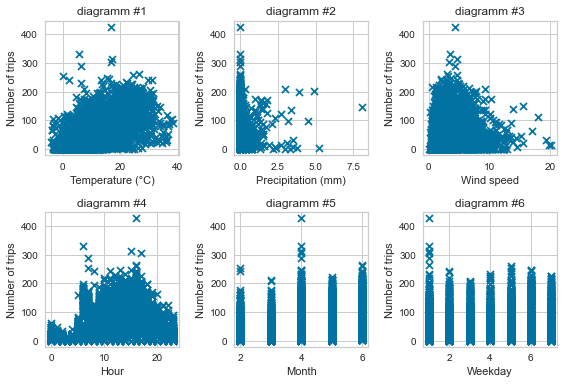

In [231]:
# df_summer = df[list(map(lambda x : str(x) in ["6", "7", "8"], df.month))].copy()

plt.subplot(2,3,1)
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of trips")
plt.title("diagramm #1")
plt.scatter(X_f["temperature"], y_f["num_trips"], marker='x')

plt.subplot(2,3,2)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of trips")
plt.title("diagramm #2")
plt.scatter(X_f["precipitation"], y_f["num_trips"], marker='x')

plt.subplot(2,3,3)
plt.xlabel("Wind speed")
plt.ylabel("Number of trips")
plt.title("diagramm #3")
plt.scatter(X_f["wind_speed"], y_f["num_trips"], marker='x')

plt.subplot(2,3,4)
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("diagramm #4")
plt.scatter(X_f["hour"], y_f["num_trips"], marker='x')

plt.subplot(2,3,5)
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.title("diagramm #5")
plt.scatter(X_f["month"], y_f["num_trips"], marker='x')

plt.subplot(2,3,6)
plt.xlabel("Weekday")
plt.ylabel("Number of trips")
plt.title("diagramm #6")
plt.scatter(X_f["weekday"], y_f["num_trips"], marker='x')

plt.tight_layout()
plt.savefig(path_fig + r'\feature_plotting.png')
plt.show()

C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


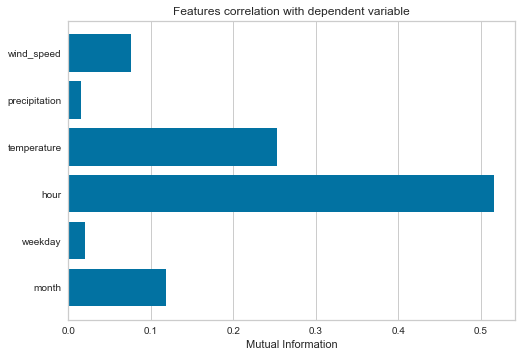

In [232]:
features = np.array(X_f.columns)

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X_f, y_f, discrete_features=discrete, random_state=1)
visualizer.show()

# 2. Model training

## 2.1 Splitting and scaling data

In [233]:
X_f_unscaled = X_f
X_b_unscaled = X_b

# X_f = StandardScaler().fit_transform(X_f)
# X_b = StandardScaler().fit_transform(X_b)

- X = temperature, precipitation, wind_speed, month, weekday, hour
- y = num_trips

In [234]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.2)

In [235]:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)

In [236]:
scaler = StandardScaler()
scaler.fit(X_b_train)

X_b_train = scaler.transform(X_b_train)
X_b_test = scaler.transform(X_b_test)

## 2.2 Linear Regression

In [237]:
model = LinearRegression(fit_intercept = True)
model.fit(X_b_train, y_b_train)

model_pred = model.predict(X_b_test)

print ('The R^2 of linear regression is: ', r2_score(y_b_test, model_pred))
print ('The mean squared error of linear regression is: ', mean_squared_error(y_b_test, model_pred))

The R^2 of linear regression is:  0.3697670277004337
The mean squared error of linear regression is:  25.549203281750355


## 2.3 Polynomial Regression

### Berlin

In [238]:
num_degree = 3

In [239]:
poly_b = PolynomialFeatures(degree = num_degree)

X_b_poly = poly_b.fit_transform(X_b)

X_b_train_poly, X_b_test_poly, y_b_train_poly, y_b_test_poly = train_test_split(X_b_poly, y_b, test_size=0.3)

In [240]:
model_poly = LinearRegression(normalize = True)
model_poly.fit(X_b_train_poly,y_b_train_poly)

y_pred = model_poly.predict(X_b_test_poly)

print ('The R^2 for polynomial regression is: ', r2_score(y_b_test_poly, y_pred))
print ('The mean squared error for polynomial regression is: ', mean_squared_error(y_b_test_poly, y_pred))

The R^2 for polynomial regression is:  -23.396650021818566
The mean squared error for polynomial regression is:  927.6662862205378


In [241]:
model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_b_train_poly, y_b_train_poly)
L2_pred = model_L2.predict(X_b_test_poly)

print ('The R^2 for ridge regession is: ', r2_score(y_b_test_poly, L2_pred))
print ('The mean squared error for ridge regession is: ', mean_squared_error(y_b_test_poly, L2_pred))

The R^2 for ridge regession is:  0.4003335312934989
The mean squared error for ridge regession is:  22.80191606218227


In [242]:
model_L1 = Lasso(alpha = 0.1, normalize = False, max_iter = 20000)

model_L1.fit(X_b_train_poly, y_b_train_poly)
L1_pred = model_L1.predict(X_b_test_poly)

print ('The R^2 for lasso regession is: ', r2_score(y_b_test_poly, L1_pred))
print ('The mean squared error for lasso regession is: ', mean_squared_error(y_b_test_poly, L1_pred))

The R^2 for lasso regession is:  0.205357517696088
The mean squared error for lasso regession is:  30.21574846434552


C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099.9256184356927, tolerance: 9.129611242362525
  model = cd_fast.enet_coordinate_descent(


### Frankfurt

In [243]:
poly_f = PolynomialFeatures(degree = num_degree)

X_f_poly = poly_f.fit_transform(X_f)

X_f_train_poly, X_f_test_poly, y_f_train_poly, y_f_test_poly = train_test_split(X_f_poly, y_f, test_size=0.3)

In [244]:
model_poly = LinearRegression(normalize = True)
model_poly.fit(X_f_train_poly, y_f_train_poly)

y_pred = model_poly.predict(X_f_test_poly)

print ('The R^2 for polynomial regression is: ', r2_score(y_f_test_poly, y_pred))
print ('The mean squared error for polynomial regression is: ', mean_squared_error(y_f_test_poly, y_pred))

The R^2 for polynomial regression is:  0.5819866859278825
The mean squared error for polynomial regression is:  1181.8919189862506


In [245]:
model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_b_train_poly, y_b_train_poly)
L2_pred = model_L2.predict(X_f_test_poly)

print ('The R^2 for ridge regession is: ', r2_score(y_f_test_poly, L2_pred))
print ('The mean squared error for ridge regession is: ', mean_squared_error(y_f_test_poly, L2_pred))

The R^2 for ridge regession is:  -0.8750581792951373
The mean squared error for ridge regession is:  5301.544317212013


In [246]:
model_L1 = Lasso(alpha = 0.1, normalize = False, max_iter = 20000)

model_L1.fit(X_f_train_poly, y_f_train_poly)
L1_pred = model_L1.predict(X_f_test_poly)

print ('The R^2 for lasso regession is: ', r2_score(y_f_test_poly, L1_pred))
print ('The mean squared error for lasso regession is: ', mean_squared_error(y_f_test_poly, L1_pred))

The R^2 for lasso regession is:  0.5816915328281778
The mean squared error for lasso regession is:  1182.726435619241


C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1051944.4119418464, tolerance: 760.2342285714286
  model = cd_fast.enet_coordinate_descent(


## 2.4 Decision Tree Regression

In [247]:
X_b_train_us, X_b_test_us, y_b_train_us, y_b_test_us = train_test_split(X_b_unscaled, y_b, test_size=0.3)

In [248]:
tree_reg = DecisionTreeRegressor(max_depth = 6)
tree_reg.fit(X_b_train_us, y_b_train_us)

tree_pred = tree_reg.predict(X_b_test_us)

print ('The R^2 for lasso regession is: ', r2_score(y_b_test_us, tree_pred))

The R^2 for lasso regession is:  0.4929121836358279


In [249]:
tree_reg.get_depth()

6

In [250]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    tree_model = DecisionTreeRegressor(max_depth = tree_depth)
    tree_model.fit(X_b_train, y_b_train) 
    
    dot_data = export_graphviz(tree_model, feature_names=["temperature", "precipitation", "wind_speed", "hour", "month", "weekday"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

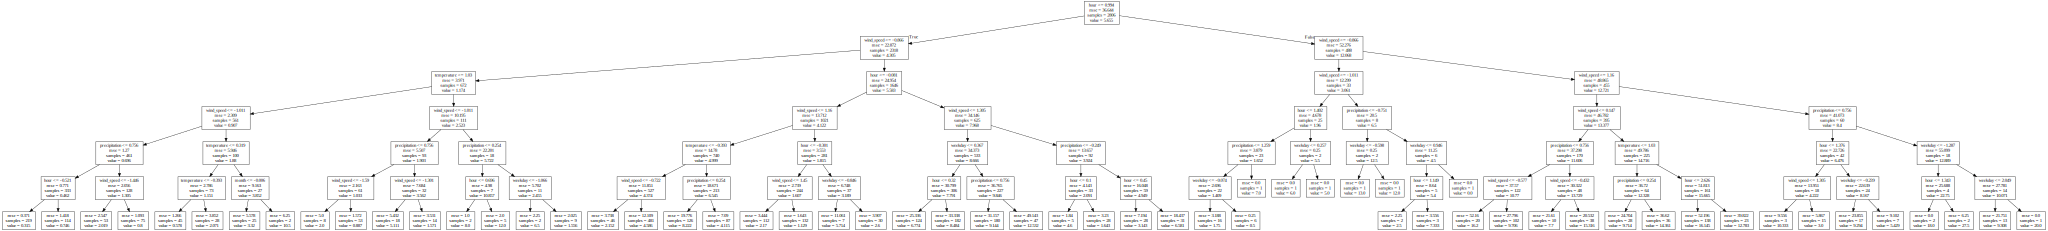

In [251]:
plot_regression_tree_sklearn(6)

## 2.5 Neural Network

In [252]:
regr = MLPRegressor(hidden_layer_sizes=(20,20,20), random_state=1, max_iter=1000).fit(X_b_train, y_b_train)
pred = regr.predict(X_b_test)

print(r2_score(y_b_test, pred))

C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5646219380092444


In [253]:
pred = pred.reshape(len(pred),1)

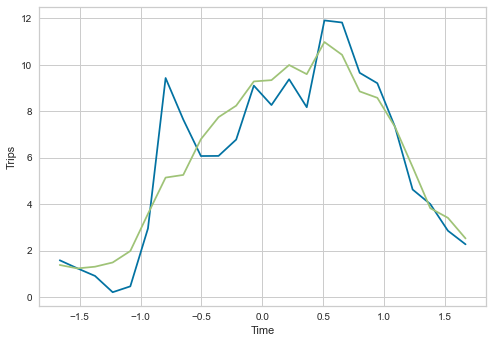

In [256]:
df_plot = pd.DataFrame()
df_plot['hour'] = X_b_test[:, 2]
df_plot['target'] = y_b_test.reset_index(drop=True)
df_plot['pred'] = pred
df_plot = df_plot.groupby(df_plot.hour).mean()
df_plot.sort_index(inplace=True)
plt.plot(df_plot.hour, df_plot.target, label='Trips in each hour')
plt.plot(df_plot.hour, df_plot.pred, label='Pred. Trips in each hour')
plt.ylabel('Trips')
plt.xlabel('Time')
# plt.xlim(0, 23)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# plt.savefig('trip_hour.png')
plt.show()